In [6]:
import sys, h5py, pdb,time, glob,os 
from importlib import reload
import pylab as pl, numpy as np
from numpy import log10 as log
from astropy import units as un, constants as cons
import scipy, scipy.stats
from matplotlib import ticker, patches
from mpl_toolkits.mplot3d import Axes3D
sys.path.append('../../pysrc')

In [7]:
import workdirs as wd
import FIRE_files as ff
from FIRE_files import cosmo, u
from projectPlotBasics import *
import first_pass as l
cmap = pl.get_cmap('viridis')
figdir = wd.basedir+'ipynb/subsonic_solution/figures/'

In [8]:
CF_path = '../../../cooling_flow/pysrc'
sys.path.append(CF_path)
import cooling_flow as CF, HaloPotential as Halo
%matplotlib inline

In [11]:
vc = 200. *un.km/un.s
#simname = 'vc200_Rs0_Mdot4847_Rcirc10_fgas02_res1e4_n10_NoLowCool_tracking'
#Rcirc = 10.*un.kpc
#Nsnapshots,dt,rmax = 225,10,40
simname = 'vc200_Rs0_Mdot1035_Rcirc15_fgas02_res1e3'
Rcirc = 15.*un.kpc
Nsnapshots,dt,rmax = 45,50,30
simdir = wd.simdir+'/%s/output/'%simname
ts = -np.arange(Nsnapshots)*dt
ts = ts-ts[-1]

In [18]:
coords,vs,Ts,nHs,tcools = np.zeros((Nsnapshots,0,3)), np.zeros((Nsnapshots,0,3)), np.zeros((Nsnapshots,0)), np.zeros((Nsnapshots,0)), np.zeros((Nsnapshots,0))
for lastSnapshot in range(50,60):#range(275,326):
    npz_fn = wd.tracksdir+simname+'/particle_tracks_%d_%d_%d_%d.npz'%(Nsnapshots*5,dt,rmax,lastSnapshot)
    #snapNumbers = range(lastSnapshot-Nsnapshots,lastSnapshot,1)
    
    if os.path.exists(npz_fn):
        f = np.load(npz_fn)
    else:
        print(npz_fn)
        continue
    coords = np.concatenate([coords,f['coords']],axis=1)
    print(lastSnapshot, coords.shape)
    vs = np.concatenate([vs,f['vs']],axis=1)
    Ts = np.concatenate([Ts,f['Ts']],axis=1)
    nHs = np.concatenate([nHs,f['nHs']],axis=1)
    tcools = np.concatenate([tcools,f['tcools']],axis=1)
    f.close()


/mnt/home/jstern/ceph/sim_analysis/particle_tracks/vc200_Rs0_Mdot1035_Rcirc15_fgas02_res1e3/particle_tracks_225_50_30_50.npz
/mnt/home/jstern/ceph/sim_analysis/particle_tracks/vc200_Rs0_Mdot1035_Rcirc15_fgas02_res1e3/particle_tracks_225_50_30_51.npz
/mnt/home/jstern/ceph/sim_analysis/particle_tracks/vc200_Rs0_Mdot1035_Rcirc15_fgas02_res1e3/particle_tracks_225_50_30_52.npz
/mnt/home/jstern/ceph/sim_analysis/particle_tracks/vc200_Rs0_Mdot1035_Rcirc15_fgas02_res1e3/particle_tracks_225_50_30_53.npz
/mnt/home/jstern/ceph/sim_analysis/particle_tracks/vc200_Rs0_Mdot1035_Rcirc15_fgas02_res1e3/particle_tracks_225_50_30_54.npz
/mnt/home/jstern/ceph/sim_analysis/particle_tracks/vc200_Rs0_Mdot1035_Rcirc15_fgas02_res1e3/particle_tracks_225_50_30_55.npz
/mnt/home/jstern/ceph/sim_analysis/particle_tracks/vc200_Rs0_Mdot1035_Rcirc15_fgas02_res1e3/particle_tracks_225_50_30_56.npz
57 (45, 114627, 3)
/mnt/home/jstern/ceph/sim_analysis/particle_tracks/vc200_Rs0_Mdot1035_Rcirc15_fgas02_res1e3/particle_track

In [14]:
npz_fn = wd.tracksdir+simname+'/particle_tracks_%d_%d_%d_all.npz'%(Nsnapshots,dt,rmax)
np.savez(npz_fn,coords=coords[:,::50,...],vs=vs[:,::50,...],Ts=Ts[:,::50,...],nHs=nHs[:,::50,...],tcools=tcools[:,::10,...])

In [15]:
npz_fn = wd.tracksdir+simname+'/particle_tracks_%d_%d_%d_all.npz'%(Nsnapshots,dt,rmax)
f = np.load(npz_fn)
coords,vs,Ts,nHs,tcools=f['coords'],f['vs'],f['Ts'],f['nHs'],f['tcools'][:,::5,...]

In [19]:
isStar = np.isnan(Ts[:,:])
tSF_ind  = np.array([np.concatenate([np.array([True]), isStar[:,i]]).nonzero()[0][-1] for i in range(isStar.shape[1])])
tSF = ts[tSF_ind]
isCool = Ts[:,:]<1e5
t105_ind = np.array([np.concatenate([np.array([True]), isCool[:,i]]).nonzero()[0][-1] for i in range(isCool.shape[1])])
t105= ts[t105_ind]

In [20]:
mu = 0.62
epsilons = Ts / (un.km**2/un.s**2 * cons.m_p / cons.k_B).to('K').value / (2./3* mu) 
cs = (epsilons*10/9)**0.5 
nHTs = nHs*Ts
Ks = (cons.k_B*Ts*un.K/(nHs*un.cm**-3)**(2/3.)).to('keV*cm**2').value

In [21]:
rhos = nHs*cons.m_p.to('g')/ff.X

In [22]:
Edots = epsilons * (un.km**2/un.s**2).to('erg*g**-1') * (dt/tcools)
dVs = np.log(nHs[:-1,:]/nHs[1:,:])
dVs = np.pad(dVs,((0,1),(0,0)),mode='constant')
PdVs = (mu * ff.X)**-1 * (cons.k_B * un.K / un.g).to('erg*g**-1') * nHTs  * dVs / rhos

In [23]:
xs,ys,zs = coords[:,:,0],coords[:,:,1],coords[:,:,2]
rs    = (xs**2+ys**2+zs**2)**0.5
Rs    = (xs**2+ys**2)**0.5
phis  = np.arctan2(ys,xs)
thetas = np.arccos(zs/rs)

In [24]:
dphis = ((phis[:-1,:]-phis[1:,:])%(2*np.pi))[::-1].cumsum(axis=0)[::-1]
dphis = np.pad(dphis,((0,1),(0,0)),mode='constant')

In [25]:
js = np.array([coords[:,:,1] * vs[:,:,2] - coords[:,:,2] * vs[:,:,1],
               coords[:,:,2] * vs[:,:,0] - coords[:,:,0] * vs[:,:,2],
               coords[:,:,0] * vs[:,:,1] - coords[:,:,1] * vs[:,:,0]])
js = np.moveaxis(js,[0,1],[2,0])
jzs = js[:,:,2]

In [26]:
vphis = jzs/Rs
Omegas = jzs/Rs**2 * un.km/un.s/un.kpc
vzs = vs[:,:,2]
vRs = (vs[:,:,0]*xs/rs + vs[:,:,1]*ys/rs)
vrs = (vs[:,:,0]*xs/rs + vs[:,:,1]*ys/rs + vs[:,:,2]*zs/rs)
v_abs = (vRs**2+vzs**2+vphis**2)**0.5
# cos𝜃cos𝜙𝐱+cos𝜃sin𝜙𝐲−sin𝜃𝐳)𝜃
vthetas = vs[:,:,0]*np.cos(thetas)*np.cos(phis) + vs[:,:,1]*np.cos(thetas)*np.sin(phis) - vs[:,:,2]*np.sin(thetas)

In [27]:
tffs   = (2**0.5*rs*un.kpc/vc).to('Myr')
trots  = (Omegas**-1).to('Myr')
tflows = (rs*un.kpc/(vrs*un.km/un.s)).to('Myr')

In [28]:
theta_midbins = np.array([0.1,0.2,0.3,0.45])*np.pi; l = len(theta_midbins)
dtheta = 0.025*np.pi
theta_inds = np.zeros((len(theta_midbins),thetas.shape[1]))
for itheta,theta_midbin in enumerate(theta_midbins):
    theta_infty = np.median(thetas[-10:,:],axis=0)
    theta_inds[itheta,:] = (theta_infty<theta_midbin+dtheta) & (theta_infty>theta_midbin-dtheta)
theta_inds = theta_inds.astype('bool')
print(theta_inds.sum(axis=1))

[ 1315  4100  5850 13102]


In [29]:
%matplotlib inline
from matplotlib import cm
def plot_helix_pylab(ax,_phis,_Rs,_zs,_Ts,_As,a=2):
    _v=pl.linspace(0,2*np.pi,40)
    [phis,v]=np.meshgrid(_phis+np.pi/2,_v)
    [zs,v]=np.meshgrid(_zs,_v)
    [Rs,v]=np.meshgrid(_Rs,_v)
    [Ts,v]=np.meshgrid(_Ts,_v)
    [As,v]=np.meshgrid(_As*a,_v)
    x=(Rs+a*As*np.cos(v))*np.cos(phis)
    y=(Rs+a*As*np.cos(v))*np.sin(phis)
    z=a*As*np.sin(v)+zs
    cc = (log(Ts)-3.5)/3; cc[cc>1] = 1; cc[cc<0] = 0    
    ax.plot_surface(x,y,z)#,facecolors=cc,cmap='summer')#(log(Ts)-3.5)/3,
                   #rstride=1, cstride=1, linewidth=0, antialiased=False)#,vmin=3.5,vmax=6.5)

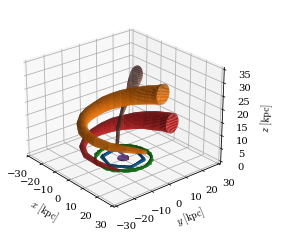

In [30]:
fig = pl.figure()
ax = pl.axes(projection='3d')
_arr = [(a,b) for a,b in enumerate(theta_midbins)]
for i,ind in (_arr[2],_arr[3],_arr[0]):
#     if i==1: continue
    med_ind = int(np.median(tSF_ind[theta_inds[i]]))
    med_dphis, med_Rs, med_zs, med_Ts, med_rhovs = [
        np.nanmedian(val[:,theta_inds[i]],axis=1)[med_ind:] for val in (dphis,Rs,zs,Ts,(nHs*v_abs)**-1)]        
    med_rhovs /= med_rhovs[-1]    
    med_rhovs[med_rhovs<0.1] = 0.1
    for j in range(2)[:]:
        Tinds = (med_Ts<=1e5, med_Ts>1e5)[j]
        if j==0: Tinds[Tinds.nonzero()[0][-1]+1]=True
        plot_helix_pylab(ax,med_dphis[Tinds],med_Rs[Tinds],med_zs[Tinds],med_Ts,med_rhovs[Tinds])
#     ax.scatter3D(_ys[::d],_xs[::d],_zs[::d],label=labels[i],color=colors[i],marker='o',s=2)
    ax.set_ylim(-30,30)
    ax.set_xlim(-30,30)
    ax.set_zlim(0,35)
    ax.view_init(25,-40)
    pl.xlabel(r'$x\ [{\rm kpc}]$')
    pl.ylabel(r'$y\ [{\rm kpc}]$')
    ax.set_zlabel(r'$z\ [{\rm kpc}]$')
#pl.savefig(figdir+'3Dtracks.pdf')

In [31]:
from mayavi import mlab
def plot_helix(ax,_phis,_Rs,_zs,_Ts,_As,a=1):
    _v=pl.linspace(0,2*np.pi,40)
    [phis,v]=np.meshgrid(_phis+np.pi/2,_v)
    [zs,v]=np.meshgrid(_zs,_v)
    [Rs,v]=np.meshgrid(_Rs,_v)
    [Ts,v]=np.meshgrid(_Ts,_v)
    [As,v]=np.meshgrid(_As*a,_v)
    x=(Rs+a*As*np.cos(v))*np.cos(phis)
    y=(Rs+a*As*np.cos(v))*np.sin(phis)
    z=a*As*np.sin(v)+zs
    cc = (log(Ts)-3.5)/3; cc[cc>1] = 1; cc[cc<0] = 0    
    ax.plot_surface(x,y,z,color=c)#,cmap='coolwarm',facecolors=my_col,#(log(Ts)-3.5)/3,
                   #rstride=1, cstride=1, linewidth=0, antialiased=False)#,vmin=3.5,vmax=6.5)


ModuleNotFoundError: No module named 'mayavi'

In [32]:
from mayavi import mlab
%gui qt
def plot_helix_mayavi(_phis,_Rs,_zs,_Ts,_As,a=2):
    _v=pl.linspace(0,2*np.pi,40)
    [phis,v]=np.meshgrid(_phis+np.pi/2,_v)
    [zs,v]=np.meshgrid(_zs,_v)
    [Rs,v]=np.meshgrid(_Rs,_v)
    [Ts,v]=np.meshgrid(_Ts,_v)
    [As,v]=np.meshgrid(_As*a,_v)
    x=(Rs+a*As*np.cos(v))*np.cos(phis)
    y=(Rs+a*As*np.cos(v))*np.sin(phis)
    z=a*As*np.sin(v)+zs
    cc = log(Ts); #(log(Ts)-3.5)/3; cc[cc>1] = 1; cc[cc<0] = 0    
    print([_i.shape for _i in (x,y,z,cc)])
#     mlab.points3d(x,y,z,_As*a*2,opacity=0.5,scalars==)
    s = mlab.mesh(x,y,z,opacity=0.5,scalars=cc,colormap='coolwarm',vmin=3.5,vmax=6.5)
#     s.module_manager.scalar_lut_manager.reverse_lut = True
    return s
#     pts = mlab.quiver3d(x, y, z, sx, sy, sz, scalars=cc, opacity=0.5,
#                         mode="sphere", scale_factor=f,colormap='coolwarm')
#     pts.glyph.color_mode = "color_by_scalar"
#     pts.glyph.glyph_source.glyph_source.center = [0,0,0]

ModuleNotFoundError: No module named 'mayavi'

In [33]:
_arr = [(a,b) for a,b in enumerate(theta_midbins)]
mlab.figure(bgcolor=(1,1,1), fgcolor=(0.,0.,0.))
for i,ind in (_arr[2],_arr[3],_arr[0]):
    med_ind = int(np.median(tSF_ind[theta_inds[i]]))
    med_dphis, med_Rs, med_zs, med_Ts, med_As = [
        np.nanmedian(val[:,theta_inds[i]],axis=1)[med_ind:] for val in (dphis,Rs,zs,Ts,(nHs*v_abs)**-1)]        
    med_As /= med_As[-1]    
    med_As[med_As<0.03] = 0.03
    print([x.shape for x in (med_dphis, med_Rs, med_zs, med_Ts, med_As)])
    plot_helix_mayavi(med_dphis,med_Rs,med_zs,med_Ts,med_As)
#     mlab.colorbar(title=r'$\log\ T\ [{\rm K}]$',orientation='vertical', label_fmt=r'$%.1f$',nb_labels=7)
ax = mlab.axes(extent=[0,40,0,40,0,40],y_axis_visibility=False,x_axis_visibility=True,z_axis_visibility=False,
             ylabel=r'$R_{\rm cyl}\,[{\rm kpc}]$',nb_labels=0,color=(0,0,0))
oa = mlab.orientation_axes()
oa.axes.x_axis_shaft_property.color = oa.axes.x_axis_tip_property.color = (0.5,0.5,0.5)
oa.axes.y_axis_shaft_property.color = oa.axes.y_axis_tip_property.color = (0.5,0.5,0.5)
oa.axes.z_axis_shaft_property.color = oa.axes.z_axis_tip_property.color = (0.5,0.5,0.5)
pl.savefig(figdir+'3Dtracks_mayavi.pdf')

NameError: name 'mlab' is not defined

[]

NameError: name 'labels' is not defined

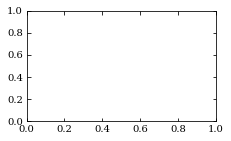

In [34]:
rCircle = 40 
fig = pl.figure(figsize=(fig_width_half,fig_width_half*0.6))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])
for i,ind in enumerate(theta_midbins):
    med_dphis, med_Rs, med_zs = [np.nanmedian(val[:,theta_inds[i]],axis=1) for val in (dphis,Rs,zs)]    
    med_ind = int(np.median(tSF_ind[theta_inds[i]]))
    pl.plot(med_Rs[med_ind:]*np.cos(med_dphis[med_ind:]),med_zs[med_ind:],label=labels[i],c=colors[i],lw=1)

ax.add_artist(patches.Circle((0, 0), rCircle,facecolor='none',edgecolor='.5',lw=0.5,ls='--'))
pl.text(-39,2,r'$r=40\ {\rm kpc}$',color='.5')
i=0; pl.text(12,40,labels_short[i],color=colors[i])
i=1; pl.text(24,33,labels[i],color=colors[i])
i=2; pl.text(32,25,labels_short[i],color=colors[i])
i=3; pl.text(32,8,labels_short[i],color=colors[i])
pl.ylim(0,45)
pl.xlim(-45,45)
pl.axvline(0,c='.5',lw=.5)
pl.ylabel(r'$z\ [{\rm kpc}]$')
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.xlabel(r'$x\ [{\rm kpc}]$')
pl.savefig(figdir+'helix.pdf',bbox_inches='tight')
# ax = fig.add_subplot(gs[2:, 0])
# for i,ind in enumerate(theta_midbins):
#     med_dphis, med_Rs, med_zs = [np.nanmedian(val[:,theta_inds[i]],axis=1) for val in (dphis,Rs,zs)]    
#     med_ind = int(np.median(tSF_ind[theta_inds[i]]))
#     pl.plot((med_Rs*np.cos(med_dphis))[med_ind:],(med_Rs*np.sin(med_dphis))[med_ind:],label=labels[i],c=colors[i],lw=0.75)
# ax.add_artist(patches.Circle((0, 0), rCircle,facecolor='none',edgecolor='.5',lw=0.5,ls='--'))
# pl.ylim(-45,45)
# pl.xlim(-45,45)
# pl.ylabel(r'$y\ [{\rm kpc}]$')

In [35]:
[np.percentile(tcools[-1,:],p) for p in (16,50,84)]

[1397.8954889469073, 2478.8701392593116, 5672.187527288032]

In [36]:
colors = pl.get_cmap('viridis')(1-np.arange(l)/(l-1))
labels_short = [(r'$%.'+'%d'%(1,2)[im==3]+'f\pi$')%m for im,m in enumerate(theta_midbins/np.pi)]
labels = [(r'$\theta_0=%.'+'%d'%(1,2)[im==3]+'f\pi$')%m for im,m in enumerate(theta_midbins/np.pi)]
def med_and_std(all_vals,xs=ts,theta_inds=theta_inds,show_std=True,ls='-'):
    for i,ind in enumerate(theta_midbins):
        vals = all_vals[:,theta_inds[i]]
        ys16,ys50,ys84 = [np.nanpercentile(vals,p,axis=1) for p in (16,50,84)]
        goods = xs<np.median(tSF[theta_inds[i]])
        pl.plot(xs[goods]/1000,ys50[goods],label=labels[i],c=colors[i],ls=ls)
        if show_std: pl.fill_between(xs[goods]/1000,ys16[goods],ys84[goods],facecolor=colors[i],alpha=0.1)    
def med_and_std_dphi(dphis,xs=ts,theta_inds=theta_inds):
    for i,ind in enumerate(theta_midbins):
        vals = dphis[:,theta_inds[i]]
        ys16,ys50,ys84 = [np.nanpercentile(vals,p,axis=1) for p in (16,50,84)]
        goods = xs<np.median(tSF[theta_inds[i]])
        for j in np.arange(0,max(ys50[goods]/(2*np.pi))+1):
            goods2 = goods & (ys50//(2*np.pi) == j)
            pl.plot(xs[goods2]/1000,ys50[goods2]/(2*np.pi)%1,label=labels[i],c=colors[i])
            pl.fill_between(xs[goods2]/1000,ys16[goods2]/(2*np.pi)%1,ys84[goods2]/(2*np.pi)%1,facecolor=colors[i],alpha=0.1)            
def relative_dispersion(all_vals,xs=ts,theta_inds=theta_inds):
    for i,ind in enumerate(theta_midbins):        
        goods = xs<np.median(tSF[theta_inds[i]])
        vals = all_vals[:,theta_inds[i]][goods,:]
        mean = np.nanmean(vals,axis=1)
        std  = np.nanstd(vals,axis=1)
        pl.plot(xs[goods]/1000,std/mean,label=labels[i],c=colors[i])

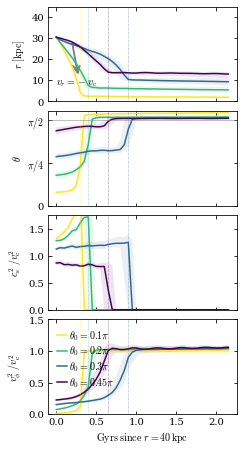

In [37]:
pl.figure(figsize=(fig_width_half,7.5)); pl.subplots_adjust(hspace=0.1)
for iPanel in range(4):
    ax = pl.subplot(4,1,iPanel+1)
    vals = (rs,thetas,(cs/vc.value)**2,(vphis/vc.value)**2)[iPanel]
    ylabel = (r'$r\ [{\rm kpc}]$', r'$\theta$', r'$c^2_{\rm s}\ / v^2_{\rm c}$',r'$v^2_\phi\ / v^2_{\rm c}$')[iPanel]
    yls = ((0,45),(0,0.55*np.pi),(0,1.75),(0,1.5))[iPanel]
    med_and_std(vals)
    pl.ylabel(ylabel)
    pl.ylim(*yls)
    [pl.axvline(np.nanmedian(t105[theta_inds[i]])/1000,c=colors[i],lw=0.5,ls=':') for i,ind in enumerate(theta_midbins)]        
    if iPanel==0:
        pl.arrow(0.2,27.5,0.05,-(0.05*un.Gyr*200*un.km/un.s).to('kpc').value,
                 color='.5',width=0.01,head_width=0.1,head_length=2,overhang=2)
#         vcool = (40.5*un.kpc/(np.median(tcools[-1,:])*un.Myr)).to('km/s')
#         pl.arrow(0.2,27.5,0.12,-(0.12*un.Gyr*vcool).to('kpc').value,
#                  color='.5',width=0.1,head_width=0.1,head_length=1,overhang=2)
        pl.text(0.25,8,r'$v_r=-v_{\rm c}$',ha='center')
        ax.yaxis.set_major_locator(ticker.MultipleLocator(10))        
    if iPanel==1:
        pl.axhline(0.5*np.pi,c='.5',lw=0.5)
        ax.yaxis.set_major_locator(ticker.FixedLocator([0,np.pi/2,np.pi/4]))
        ax.yaxis.set_major_formatter(ticker.FixedFormatter(['0',r'$\pi/2$',r'$\pi/4$']))
    if iPanel<3:
        ax.xaxis.set_major_formatter(ticker.NullFormatter())
    else:
        pl.legend(loc='upper left',ncol=1,frameon=False,labelspacing=0.2,handlelength=1,columnspacing=0.5,handletextpad=0.2)
        pl.xlabel(r'${\rm Gyrs\ since}\ r=40\,{\rm kpc}$')
#pl.savefig(figdir+'tracking_spherical_coordinates.pdf',bbox_inches='tight')

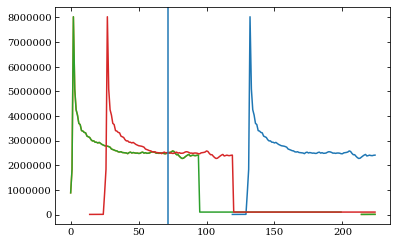

In [405]:
pl.plot(Ts[:,15])
tmp = np.roll(Ts[:,15],-130)
pl.plot(tmp)
tmp[225-130:225-25] = 1e5
pl.plot(tmp)
tmp = np.roll(tmp,25)
pl.plot(tmp)
pl.axvline(Ts.shape[0]-153)

In [38]:
time_after_105 = 25
ts_offset = -np.arange(-time_after_105*dt,(Nsnapshots-time_after_105)*dt,dt)
def shift_arr(arr,t_offset_ind):
    shifted_arr = np.zeros(arr.shape)
    for i in range(arr.shape[1]):
        shifted_arr[:,i] = np.roll(arr[:,i],-t_offset_ind[i])
        shifted_arr[Nsnapshots-t_offset_ind[i]:Nsnapshots-time_after_105,i] = -100
    return np.roll(shifted_arr, time_after_105,axis=0)

def med_and_std_shift(all_vals,xs=ts_offset,theta_inds=theta_inds,show_std=True,ls='-'):
    for i,ind in enumerate(theta_midbins):
        _vals = all_vals[:,theta_inds[i]]
        vals = shift_arr(_vals,t105_ind[theta_inds[i]])
        ys16,ys50,ys84 = [np.nanpercentile(vals,p,axis=1) for p in (16,50,84)]
        inds = ys16>0
        pl.plot(xs[inds]/1000,ys50[inds],label=labels[i],c=colors[i],ls=ls)
        if show_std: pl.fill_between(xs[inds]/1000,ys16[inds],ys84[inds],facecolor=colors[i],alpha=0.1)    

def relative_dispersion_shift(all_vals,xs=ts_offset,theta_inds=theta_inds):
    for i,ind in enumerate(theta_midbins):        
        _vals = all_vals[:,theta_inds[i]]
        vals = shift_arr(_vals,t105_ind[theta_inds[i]])
        ys16,ys50,ys84 = [np.nanpercentile(vals,p,axis=1) for p in (16,50,84)]
        inds = ys16>0
        pl.plot(xs[inds]/1000,(ys84-ys16)[inds]/2/ys50[inds],label=labels[i],c=colors[i])

Text(0.5, 0, '${\\rm Gyrs}\\ {\\rm since}\\ 10^5\\ {\\rm K}$')

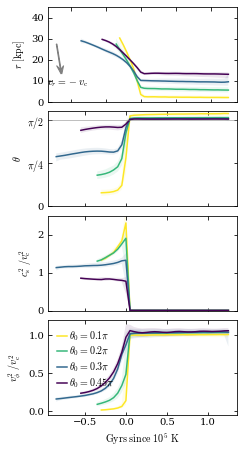

In [40]:
pl.figure(figsize=(fig_width_half,7.5)); pl.subplots_adjust(hspace=0.1)
ax = pl.subplot(411)
med_and_std_shift(rs)
pl.ylabel(r'$r\ [{\rm kpc}]$')
pl.ylim(0,45)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.arrow(-1.2,27.5,0.05,-(0.05*un.Gyr*200*un.km/un.s).to('kpc').value,color='.5',width=0.01,head_width=0.1,head_length=2,overhang=2)
pl.text(-1.05,8,r'$v_r=-v_{\rm c}$',ha='center')
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax =pl.subplot(412)
med_and_std_shift(thetas,xs=ts_offset)
pl.ylabel(r'$\theta$')
pl.ylim(0,0.55*np.pi)
pl.axhline(0.5*np.pi,c='.5',lw=0.5)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.yaxis.set_major_locator(ticker.FixedLocator([0,np.pi/2,np.pi/4]))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(['0',r'$\pi/2$',r'$\pi/4$']))
ax = pl.subplot(413)
med_and_std_shift((cs/vc.value)**2,xs=ts_offset)
pl.ylabel(r'$c^2_{\rm s}\ / v^2_{\rm c}$')
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.ylim(0,2.5)
ax = pl.subplot(414)
med_and_std_shift((vphis/vc.value)**2,xs=ts_offset)
pl.ylabel(r'$v^2_\phi\ / v^2_{\rm c}$')
pl.legend(loc='upper left',ncol=1,frameon=False,labelspacing=0.2,handlelength=1,columnspacing=0.5,handletextpad=0.2)
pl.xlabel(r'${\rm Gyrs}\ {\rm since}\ 10^5\ {\rm K}$')
#pl.savefig(figdir+'tracking_spherical_coordinates_vs_t105.pdf',bbox_inches='tight')

Text(0.5, 0, '${\\rm time}\\ [{\\rm Gyr}]$')

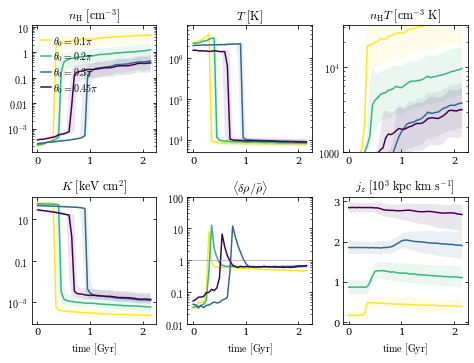

In [41]:
pl.figure(figsize=(fig_width_full*1.1,5.5)); pl.subplots_adjust(hspace=0.35,wspace=0.25)
ax = pl.subplot(231)
med_and_std(nHs)
pl.title(r'$n_{\rm H}\ [{\rm cm}^{-3}]$')
pl.legend(loc='upper left',ncol=1,frameon=False,labelspacing=0.2,handlelength=1,columnspacing=0.5,handletextpad=0.2)
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
ax = pl.subplot(232)
med_and_std(Ts)
pl.title(r'$T\ [{\rm K}]$')
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
ax = pl.subplot(233)
med_and_std(nHTs)
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.title(r'$n_{\rm H} T\ [{\rm cm}^{-3}\ {\rm K}]$')
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.ylim(1e3,10**4.5)
ax = pl.subplot(234)
med_and_std(Ks)
pl.title(r'$K\ [{\rm keV}\ {\rm cm}^2]$')
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.xlabel(r'${\rm time}\ [{\rm Gyr}]$')
ax = pl.subplot(235)
relative_dispersion(nHs)
pl.semilogy()
pl.title(r'$\langle\delta \rho/\bar \rho\rangle$')
ax.yaxis.set_major_formatter(u.arilogformatter)
pl.ylim(0.01,100)
pl.axhline(1,c='.5',lw=0.5)
pl.xlabel(r'${\rm time}\ [{\rm Gyr}]$')
ax = pl.subplot(236)
med_and_std(jzs/1000)
pl.title(r'$j_z\ [10^3\ {\rm kpc}\ {\rm km}\ {\rm s}^{-1}]$')
pl.xlabel(r'${\rm time}\ [{\rm Gyr}]$')

#pl.savefig(figdir+'tracking_properties.pdf',bbox_inches='tight')

(-1.0, 0.35)

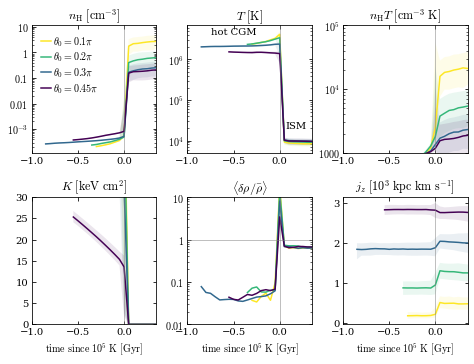

In [42]:
xls = -1.,0.35
pl.figure(figsize=(fig_width_full*1.1,5.5)); pl.subplots_adjust(hspace=0.35,wspace=0.25)
ax = pl.subplot(231)
med_and_std_shift(nHs)
pl.title(r'$n_{\rm H}\ [{\rm cm}^{-3}]$')
pl.legend(loc='upper left',ncol=1,frameon=False,labelspacing=0.2,handlelength=1,columnspacing=0.5,handletextpad=0.2)
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)
ax = pl.subplot(232)
med_and_std_shift(Ts)
pl.title(r'$T\ [{\rm K}]$')
pl.text(-0.5,4e6,r'hot CGM',ha='center')
pl.text(0.175,2e4,r'ISM',ha='center')
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)
ax = pl.subplot(233)
med_and_std_shift(nHTs)
pl.title(r'$n_{\rm H} T\ [{\rm cm}^{-3}\ {\rm K}]$')
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
pl.ylim(1e3,1e5)
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)
ax = pl.subplot(234)
med_and_std_shift(Ks)
pl.title(r'$K\ [{\rm keV}\ {\rm cm}^2]$')
pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
pl.ylim(0,30)
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)
ax = pl.subplot(235)
relative_dispersion_shift(nHs)
pl.semilogy()
pl.title(r'$\langle\delta \rho/\bar \rho\rangle$')
ax.yaxis.set_major_formatter(u.arilogformatter)
pl.ylim(0.01,10)
pl.axhline(1,c='.5',lw=0.5)
pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)
ax = pl.subplot(236)
med_and_std_shift(jzs/1000)
pl.title(r'$j_z\ [10^3\ {\rm kpc}\ {\rm km}\ {\rm s}^{-1}]$')
pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
pl.axvline(0,c='.5',lw=0.5)
pl.xlim(*xls)
#pl.savefig(figdir+'tracking_properties_vs_t105.pdf',bbox_inches='tight')

In [96]:
def med_and_std_shift_only_data(all_vals,theta_inds=theta_inds):
    res = []
    for i,ind in enumerate(theta_midbins):
        _vals = all_vals[:,theta_inds[i]]
        vals = shift_arr(_vals,t105_ind[theta_inds[i]])
        ysmean = np.nanmean(vals,axis=1)
        ys16,ys50,ys84 = [np.nanpercentile(vals,p,axis=1) for p in (16,50,84)]
        res.append((ys16,ys50,ys84,ysmean))
    return res

a = list(med_and_std_shift_only_data(PdVs))
b = list(med_and_std_shift_only_data(Edots))

In [90]:
print(a[-1][0][::10])
print(b[-1][0][::10])

[-1.05398861e+12 -9.51608607e+11 -9.12654677e+11 -1.78513002e+12
 -1.08907774e+12 -1.29186695e+12 -2.15508716e+12 -2.14004668e+12
 -2.85866238e+12 -2.21683341e+12 -2.15081183e+12 -2.19396097e+12
 -2.05079637e+12 -2.37654332e+12 -2.33253808e+12 -2.64565135e+12
 -3.18605147e+12 -3.48408440e+12 -4.04219204e+12 -3.80814326e+12
 -2.34746175e+12 -1.00000000e+02 -1.00000000e+02]
[ 2.99953013e+13  5.35559435e+13  6.56829500e+13  7.45234430e+12
  5.77270324e+12  4.67028206e+12  3.94469876e+12  3.43046760e+12
  3.02744148e+12  2.71555613e+12  2.45756453e+12  2.23520460e+12
  2.04879345e+12  1.88875960e+12  1.75109659e+12  1.63140775e+12
  1.53005825e+12  1.43912337e+12  1.35655834e+12  1.25299717e+12
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02]


In [ ]:
#P = 2.3 nH k T
#epsilon = erg/g
#epsilons * (cons.m_p / cons.k_B) *2/3mu = Ts .to('K').value 

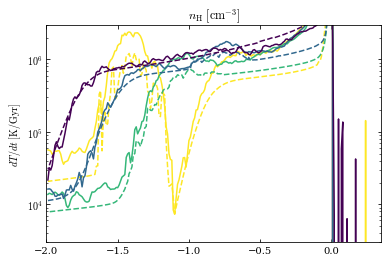

In [105]:
xls = -2.,0.35
ax = pl.subplot(111)
for i,ind in enumerate(theta_midbins):    
    for ii,(ys16,ys50,ys84,ysmean) in enumerate((a[i],b[i])):
#         inds = ys16>0    
        ysmean = ysmean * 2/3*mu * (un.erg/un.g * cons.m_p / cons.k_B /(10*un.Myr)).to('K/Gyr')
        pl.plot(ts_offset/1000,ysmean,label=labels[i],c=colors[i],ls=('-','--')[ii])
#         pl.fill_between(ts_offset[inds]/1000,ys16[inds],ys84[inds],facecolor=colors[i],alpha=0.1)    
pl.title(r'$n_{\rm H}\ [{\rm cm}^{-3}]$')
# pl.legend(loc='upper left',ncol=1,frameon=False,labelspacing=0.2,handlelength=1,columnspacing=0.5,handletextpad=0.2)
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.xlim(*xls)
pl.ylim(3e3,3e6)
pl.ylabel(r'$dT/dt\ [{\rm K/Gyr}]$')
pl.axvline(0,c='.5',lw=0.5)
# pl.savefig(figdir+'tracking_properties_vs_t105.pdf',bbox_inches='tight')

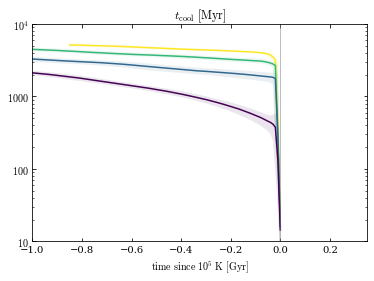

In [490]:
ax=pl.subplot(111)
med_and_std_shift(shift_arr(tcools))
pl.title(r'$t_{\rm cool}\ [{\rm Myr}]$')
pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.ylim(10,10000)
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)

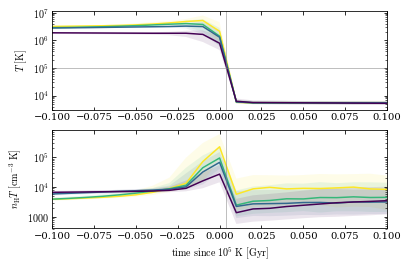

In [497]:
xls = -0.1,0.1
ax=pl.subplot(211)
med_and_std_shift(shift_arr(Ts))
pl.ylabel(r'$T\ [{\rm K}]$')
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.xlim(*xls)
pl.axvline(0.004,c='.5',lw=0.5)
pl.axhline(1e5,c='.5',lw=0.5)
ax = pl.subplot(212)
med_and_std_shift(shift_arr(nHTs))
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.ylabel(r'$n_{\rm H} T\ [{\rm cm}^{-3}\ {\rm K}]$')
pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
pl.xlim(*xls)
pl.axvline(0.004,c='.5',lw=0.5)

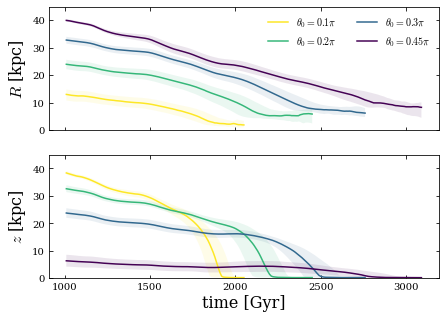

In [180]:
pl.figure(figsize=(7,5))
ax = pl.subplot(211)
med_and_std(Rs)
pl.ylabel(r'$R$ [kpc]',fontsize=16)
pl.legend(loc='upper right',ncol=2,frameon=False,labelspacing=0.5)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.ylim(0,45)
pl.subplot(212)
med_and_std(zs)
pl.ylabel(r'$z$ [kpc]',fontsize=16)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.xlabel(r'time [Gyr]',fontsize=16)
pl.ylim(0,45)
pl.savefig('tracking_cylindrical_coordinates.pdf')

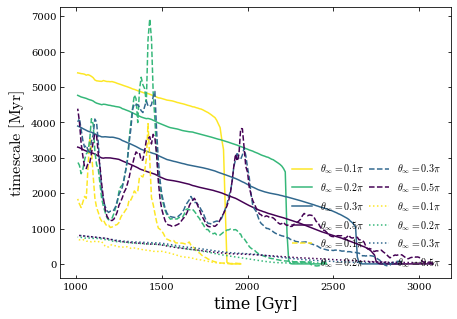

In [50]:
pl.figure(figsize=(7,5))
med_and_std(tcools,ls='-',show_std=False)
med_and_std(-tflows,ls='--',show_std=False)
med_and_std(trots,ls=':',show_std=False)
pl.ylabel(r'${\rm timescale}\ [{\rm Myr}]$',fontsize=16)
pl.legend(loc='lower right',ncol=2,frameon=False,columnspacing=0.5)
pl.xlabel(r'time [Gyr]',fontsize=16)
pl.savefig('tracking_timescale.pdf')

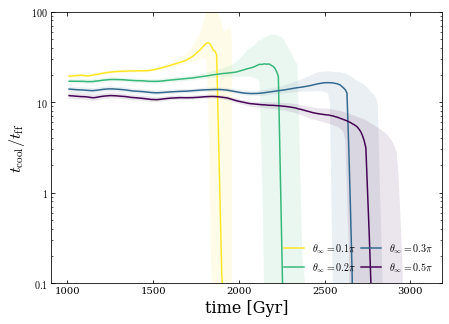

In [52]:
pl.figure(figsize=(7,5))
ax=pl.subplot(111)
med_and_std(tcools/tffs)
pl.ylabel(r'$t_{\rm cool}/t_{\rm ff}$',fontsize=16)
pl.legend(loc='lower right',ncol=2,frameon=False,columnspacing=0.5)
pl.xlabel(r'time [Gyr]',fontsize=16)
pl.semilogy()
pl.ylim(0.1,100)
ax.yaxis.set_major_formatter(u.arilogformatter)
pl.savefig('tracking_tcool_to_tff.pdf')

In [55]:
(2**0.5*10*un.kpc/(200*un.km/un.s)).to('Myr')

<Quantity 69.14035105 Myr>

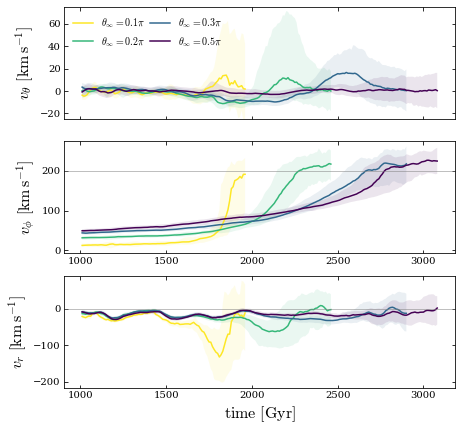

In [134]:
pl.figure(figsize=(7,7))
ax = pl.subplot(311)
med_and_std(vthetas)
pl.ylabel(r'$v_\theta\ [{\rm km}\,{\rm s}^{-1}]$',fontsize=16)
pl.legend(loc='upper left',ncol=2,frameon=False,columnspacing=0.5)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.ylim(-25,75)
pl.subplot(312)
med_and_std(vphis)
pl.ylabel(r'$v_\phi\ [{\rm km}\,{\rm s}^{-1}]$',fontsize=16)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.axhline(200,c='.5',lw=0.5)
pl.subplot(313)
med_and_std(vrs)
pl.ylabel(r'$v_r\ [{\rm km}\,{\rm s}^{-1}]$',fontsize=16)
pl.xlabel(r'${\rm time}\ [{\rm Gyr}]$',fontsize=16)
pl.axhline(0,c='.5',lw=0.5)
pl.savefig('tracking_velocity.pdf')

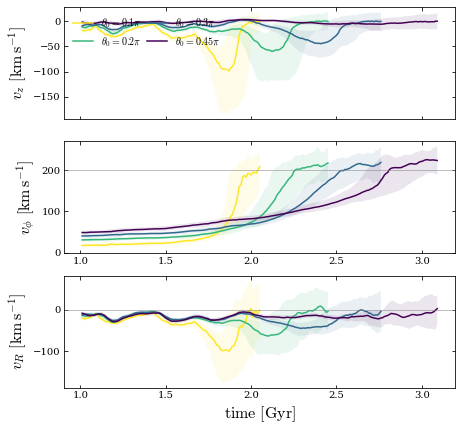

In [436]:
pl.figure(figsize=(7,7))
ax = pl.subplot(311)
med_and_std(vzs)
pl.ylabel(r'$v_z\ [{\rm km}\,{\rm s}^{-1}]$',fontsize=16)
pl.legend(loc='upper left',ncol=2,frameon=False,columnspacing=0.5)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
# pl.ylim(-25,75)
pl.subplot(312)
med_and_std(vphis)
pl.ylabel(r'$v_\phi\ [{\rm km}\,{\rm s}^{-1}]$',fontsize=16)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.axhline(200,c='.5',lw=0.5)
pl.subplot(313)
med_and_std(vrs)
pl.ylabel(r'$v_R\ [{\rm km}\,{\rm s}^{-1}]$',fontsize=16)
pl.xlabel(r'${\rm time}\ [{\rm Gyr}]$',fontsize=16)
pl.axhline(0,c='.5',lw=0.5)
pl.savefig('tracking_velocity_cylindrical.pdf')

(1000000.0, 5000000.0)

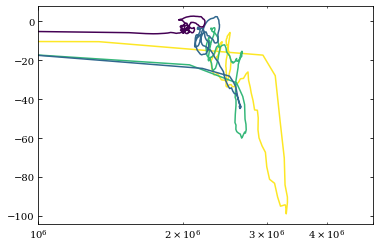

In [446]:
for i,inds in enumerate(theta_inds):
    pl.plot(np.nanmedian(Ts[:,inds],axis=1),
            np.nanmedian(vzs[:,inds],axis=1),
           c=colors[i],label=labels[i])
pl.semilogx()
pl.xlim(1e6,5e6)

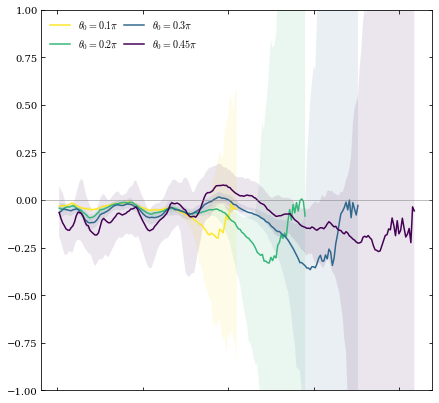

In [439]:
pl.figure(figsize=(7,7))
ax = pl.subplot(111)
# g = vc^2/r * z/R ~ vc^2 z / R^2
# gz = vc^2 z^2 / R^2
# vc_eff = vc*z/R
med_and_std(vzs/(200 * zs/Rs))
# pl.ylabel(r'$v_z\ [{\rm km}\,{\rm s}^{-1}]$',fontsize=16)
pl.legend(loc='upper left',ncol=2,frameon=False,columnspacing=0.5)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.ylim(-1,1)
pl.axhline(0,c='.5',lw=0.5)
# pl.savefig('tracking_velocity_cylindrical.pdf')

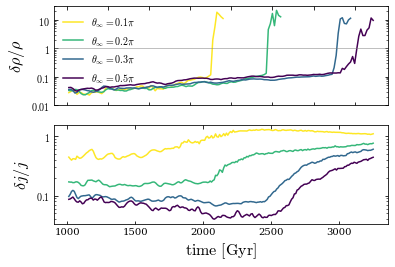

In [66]:
relative_dispersion(jzs)
pl.semilogy()
pl.ylabel(r'$\delta j/j$',fontsize=16)
pl.xlabel(r'${\rm time}\ [{\rm Gyr}]$',fontsize=16)
ax.yaxis.set_major_formatter(u.arilogformatter)
pl.savefig('tracking_dispersion.pdf')

/home/ysz5546/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


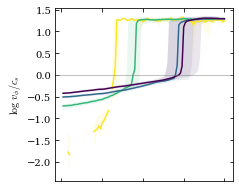

In [227]:
pl.figure(figsize=(7,7))
ax = pl.subplot(221)
med_and_std(log(vphis/cs))
pl.ylabel(r'$\log\ v_\phi/c_s$')
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.axhline(0,lw=0.5,c='.5')
# ax = pl.subplot(222)
# med_and_std(log(nHs))
# pl.ylabel(r'$\log\ n_{\rm H}$')
# pl.legend(loc='upper left',ncol=2,frameon=False,columnspacing=0.5)
# ax.xaxis.set_major_formatter(ticker.NullFormatter())
# pl.subplot(223)
# med_and_std(log(nHTs))
# pl.ylabel(r'$\log\ n_{\rm H} T$')
# pl.xlabel(r'time [Gyr]')
# pl.subplot(224)
# med_and_std(log(Ks))
# pl.ylabel(r'$\log\ K$')
# pl.xlabel(r'time [Gyr]')